In [1]:
using DifferentialEquations
using Plots
using Quadrature
using Roots
using DelimitedFiles

In [2]:
function piece_wise_linear(x_interval, y_interval, x) #these are the intervals in the x and y, each interval will have a lin fuunction
    if x < x_interval[1,1]
        my_i = 1;
    end
    if x >= x_interval[end, 2]
        my_i = size(x_interval,1);
    end
    for i = 1:size(x_interval, 1)
        if x_interval[i,1] <= x && x < x_interval[i, 2]
            my_i = i;
        end
    end
    a = (x - x_interval[my_i, 1])/(x_interval[my_i,2] - x_interval[my_i,1]);
    return a * y_interval[my_i,2] + (1 - a) * y_interval[my_i,1];
end

piece_wise_linear (generic function with 1 method)

In [3]:
function ideal_gas_der(ρ, par)
    k,γ = par
    return k*γ*ρ^(γ - 1)
end
function piece_wise_linear_csound(ρ, par)
    return piece_wise_linear(par[1], par[2], ρ) #par is an array with x_int and y_int
end
function integrate_EOS(ρ, der, par) #pressure comes from here
    prob = QuadratureProblem(der, 0.0, ρ, par)
    sol = solve(prob, QuadGKJL())#,reltol = 1e-10)
    return sol[1]
end

integrate_EOS (generic function with 1 method)

In [4]:
function make_TOV(ρ₀, dP, par)
    function TOV_equations!(du, u, par, r)
        myRho = u[1]
        myM = u[2]
        myP = u[3] 
        mydP = dP(myRho, par) #equal to dp/dρ

        if r <= 0.0
            du[1] = 0.0
            du[2] = 0.0
            du[3] = 0.0
        else
            du[3] = -((myM + 4π*(r^3)*myP)*(myRho + myP)) / (r*(r - 2*myM)) #this is pressure
            du[2] = (4π*r^2)*myRho #this is mass
            du[1] = du[3]/mydP #this is density
        end
    end
    u0 = [ρ₀, 0.0, integrate_EOS(ρ₀, dP, par)];
    Rmin = 0.0; Rguess = Inf ;
    prob = ODEProblem(TOV_equations!, u0, (Rmin, Rguess), par)
    TOV = init(prob, Tsit5(), dtmax=0.05, force_dtmin=true)
    R = 0.0
    while true
        T_Old = TOV.t #old radius
        step!(TOV)
        if TOV.u[1] < 0.0 #find zero
            f(r) = TOV.sol(r)[1] #density as function of radius
            R = find_zero(f, (T_Old, TOV.t), Order1())
            break
        end
    end
    return TOV.sol, R
end

make_TOV (generic function with 1 method)

In [5]:
function make_TOV_sequence(ρc, dP, par)
    mass = []
    radius = []
    for ρ₀ in ρc
        TOV,R = make_TOV(ρ₀, dP, par)
        push!(mass, TOV(R)[2])
        push!(radius,R)
    end
    return mass, radius
end

make_TOV_sequence (generic function with 1 method)

In [6]:
γ = 2; k = 123
P(ρ) = 123*ρ^2
dP(ρ) = 2*P(ρ)/ρ

print(P(1e-6),"\n", integrate_EOS(1e-6, ideal_gas_der, [123,2]))

1.23e-10
1.2299999999999996e-10

In [7]:
TOV, R = make_TOV(1e-3, ideal_gas_der, [123,2])
@time TOV, R = make_TOV(1e-3, ideal_gas_der, [123,2])
print(R)

  0.001003 seconds (3.04 k allocations: 271.320 KiB)
11.111051119437711

 42.454759 seconds (42.62 M allocations: 1.724 GiB, 2.45% gc time, 15.98% compilation time)


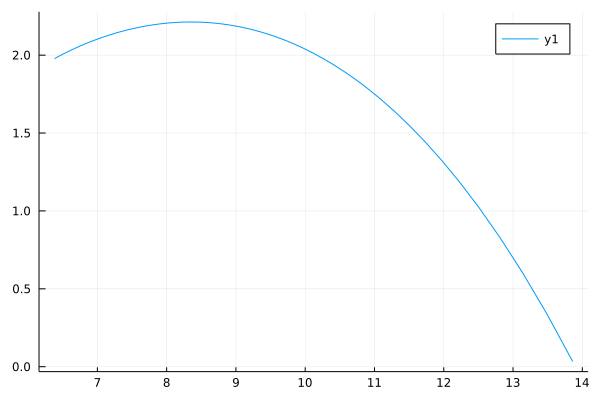

In [8]:
ρ₀ = collect(1.0e-2:1.0e-2:2.0e-2)
M,R = make_TOV_sequence(ρ₀, ideal_gas_der, [123,2])
@time begin
    ρ₀ = collect(1.0e-5:1.0e-4:1.0e-2)
    M,R = make_TOV_sequence(ρ₀, ideal_gas_der, [123,2])
    plot(R, M)
end

In [9]:
ρ₀ = collect(1.0e-5:1.0e-4:1.0e-2);
x_interval = [0.0 2.683985562445732e-10; 2.683985562445732e-10 0.001387090243627891; 0.001387090243627891 0.0014224520180366636; 0.0014224520180366636 0.003935205491747961; 0.003935205491747961 0.01783099866626234];
y_interval = [0.0 0.0003043663708371769; 0.0003043663708371769 0.34006522767154; 0.34006522767154 0.33222981114647837; 0.33222981114647837 0.500866829421404; 0.500866829421404 0.6223683933290903];
M,R = make_TOV_sequence(ρ₀, piece_wise_linear_csound, [x_interval, y_interval])
plot(R,M)


@time begin
    ρ₀ = collect(1.0e-5:1.0e-4:1.0e-2);
    M,R = make_TOV_sequence(ρ₀, piece_wise_linear_csound, [x_interval, y_interval])
    plotlyjs()
    plot(R, M)
end

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5182279086075673498\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12052859825475137381\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5182279086075673498\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

 62.766573 seconds (69.58 M allocations: 2.390 GiB, 2.26% gc time)


In [10]:
ρ₀ = collect(1.0e-5:1.0e-4:1.0e-2);
x_interval = [0.0 2.121710214285006e-13; 2.121710214285006e-13 0.0014594123379490006; 0.0014594123379490006 0.0023525678858535635; 0.0023525678858535635 0.0026531025371383686; 0.0026531025371383686 0.007690387374332126];
y_interval = [0.0 1.096376754968612e-5; 1.096376754968612e-5 0.3739156386788699; 0.3739156386788699 0.4155102040816361; 0.4155102040816361 0.5193484129953385; 0.5193484129953385 0.6934721512519161];
M,R = make_TOV_sequence(ρ₀, piece_wise_linear_csound, [x_interval, y_interval])
plot(R,M)


@time begin
    ρ₀ = collect(1.0e-5:1.0e-4:1.0e-2);
    M,R = make_TOV_sequence(ρ₀, piece_wise_linear_csound, [x_interval, y_interval])
    plotlyjs()
    plot(R, M)
end

  0.166346 seconds (282.45 k allocations: 23.129 MiB, 37.36% gc time)


In [14]:
using DelimitedFiles
using Plots

g = readdlm("tov_seq_pwp2.dat")


TMASS = g[4:203]
TRAD = g[207:406]

plot(R*1.482, M, xlabel = "Radius (km)", ylabel = "Mass (M⊙)", label = "Clean Up", title = "Neutron Stars K = 123, γ = 2", linewidth = 2)
plot!(TMASS, TRAD, label = "Rahul", linestyle = :dash, linewidth = 4, color = :black)

LoadError: ArgumentError: Cannot open 'tov_seq_pwp2.dat': not a file

In [12]:
k = 123.0; γ = 2.0

P(ρ) = k*ρ^γ
dP(ρ) = γ*P(ρ)/ρ

#TOV, R = make_TOV(1.0e-2, P, dP)

#plot(TOV, vars = 1) #(RADIUS, DENSITY)

#plot(ρ₀ * 6.17e17, M, xlabel = "Central Density (g/cm³)", ylabel = "Mass (M⊙)", label = "Mat", title = "Neutron Stars K = 123, γ = 2", linewidth = 2)

dP (generic function with 1 method)